In [24]:
import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil

# Dataset download

In [ ]:
# Downloading LibriSpeech Dataset
!wget http://openslr.elda.org/resources/12/dev-clean.tar.gz

In [ ]:
# Ectracting LibriSpeech
!tar -xvf "./content/dev-clean.tar.gz"

In [ ]:
# Creating folder for all clean speech
!mkdir ./content/clean_speech

In [ ]:
# All clean speech files in clean_speech folder
o=0
for root,dir,files in os.walk("./content/LibriSpeech/dev-clean/"):
  for file in files:
    if file.endswith(".flac"):
      o+=1
      path_file = os.path.join(root,file)
      shutil.copy2(path_file,"./content/clean_speech")
print(o)

In [ ]:
# Deleting the original LibriSpeech dataset
!rm -r ./content/LibriSpeech

In [ ]:
# Downloading ESC-50 dataset
!wget https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master

In [ ]:
!unzip "./content/master"

In [ ]:
!mkdir ./content/noise

In [ ]:
# All noise audio files in noise folder
o=0
for root,dir,files in os.walk("./content/ESC-50-master/audio/"):
  for file in files:
    if file.endswith(".wav"):
      o=o+1
      path_file = os.path.join(root,file)
      shutil.copy2(path_file,"./content/noise")
print(o)

In [ ]:
# Deleting original ESC-50 dataset
!rm -r ./content/ESC-50-master

In [ ]:
count_clean = 0
duration_clean = 0
duration_noise = 0
sample_rate=8000

for i in os.listdir('./content/clean_speech'):
  count_clean += 1
  y,sr = librosa.load(os.path.join('./content/clean_speech',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_clean+=duration

print(f'Number of clean audio files are {count_clean}')
print(f'Total duration of all clean audios {duration_clean//60}')

count_noise = 0
for i in os.listdir('./content/noise'):
  count_noise += 1
  y,sr = librosa.load(os.path.join('./content/noise',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_noise+=duration

print(f'Number of Noisy audio files are {count_noise}')
print(f'Total duration of all noise audios {duration_noise//60}')

# Create dataset

In [302]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]
    # Creating several audio frames using sliding windows
    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    # Combining all the frames to single matrix
    sound_data_array = np.vstack(sound_data_list)
    return sound_data_array

In [303]:
# Required variables for Audio
noise_dir="./content/noise/"
voice_dir="./content/clean_speech/"
path_save_spectrogram="./content/spectogram/"
sample_rate=8000
min_duration=1.0  #sec
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=500  #number of mixed samples
n_fft=255
hop_length_fft=63
dim_square_spec = int(n_fft / 2) + 1

In [304]:
# clean Audio files
clean_audio_files = os.listdir(voice_dir)
# Selecting a random audio from clean speech
clean_random_audio = np.random.choice(clean_audio_files)
# Load Audio
y,sr = librosa.load(os.path.join(voice_dir,clean_random_audio),sr=sample_rate)
# Converting to Audio to numpy matrix
clean = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Clean Audio: {}".format(clean_random_audio))
print("Shape:{}".format(clean.shape))

Clean Audio: 3853-163249-0012.flac
Shape:(14, 8064)


In [305]:
# Noisy Audio files
noisy_audio_files = os.listdir(noise_dir)
# Selecting a random audio from noise data
noisy_random_audio = np.random.choice(noisy_audio_files)
# Load Audio
y,sr = librosa.load(os.path.join(noise_dir,noisy_random_audio),sr=sample_rate)
# Converting the Audio to numpy matrix
noise = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Noise Audio: {}".format(noisy_random_audio))
print("Shape:{}".format(noise.shape))

Noise Audio: 4-181999-A-36.wav
Shape:(4, 8064)


In [306]:
clean = np.vstack(clean)
noise = np.vstack(noise)

In [307]:
print(clean)
print(noise)

[[-0.00730407 -0.00915471 -0.00681089 ...  0.34946564  0.22594514
  -0.05165917]
 [-0.2298193  -0.4033982  -0.11214969 ... -0.11352298 -0.05337631
  -0.03420921]
 [-0.01320352  0.11252283  0.1386284  ... -0.03302246  0.01861686
  -0.02076206]
 ...
 [-0.01537574 -0.00562937  0.00623212 ...  0.01582691  0.02346162
   0.02081984]
 [ 0.01379407  0.01266508  0.01651824 ... -0.00082676  0.00150566
  -0.00261733]
 [ 0.00116163 -0.00185075  0.00046202 ... -0.00970528 -0.03344152
  -0.04244745]]
[[-0.07311919  0.2294228   0.17160596 ... -0.15541214 -0.03424006
   0.39136133]
 [ 0.15305546  0.07573617  0.22322425 ... -0.23186995 -0.6154634
  -0.2675646 ]
 [-0.040899   -0.43119404 -0.16306317 ... -0.04112381 -0.34206742
  -0.09904404]
 [-0.1143997   0.25160548  0.27166405 ...  0.08836555 -0.19935007
   0.34920377]]


In [308]:
#Ascolta cosa hai creato

# Saving and playing clean voice
import soundfile as sf
print(np.shape(clean))
clean_nb_samples = clean.shape[0]
print(np.shape(clean_nb_samples))
#Save all frames in one file
clean_long = clean.reshape(1, clean.shape[0] * frame_length)
print(np.shape(clean_long))
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("clean_long.wav", clean_long[0,:], 8000, 'PCM_24')

from IPython.display import Audio
Audio('clean_long.wav')

(14, 8064)
()
(1, 112896)


In [309]:
#Ascolta cosa hai creato

# Saving and playing noise
import soundfile as sf
print(np.shape(noise))
noise_nb_samples = noise.shape[0]
print(np.shape(noise_nb_samples))
#Save all frames in one file
noise_long = noise.reshape(1, noise.shape[0] * frame_length)
print(np.shape(noise_long))
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("noise_long.wav", noise_long[0,:], 8000, 'PCM_24')

from IPython.display import Audio
Audio('noise_long.wav')

(4, 8064)
()
(1, 32256)


In [310]:
def blend_noise_randomly(voice, noise, nb_samples, frame_length):
    """This function takes as input numpy arrays representing frames
    of voice sounds, noise sounds and the number of frames to be created
    and return numpy arrays with voice randomly blend with noise"""

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        noise_min=0.2
        noise_max=0.8
        level_noise = np.random.uniform(noise_min, noise_max)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice

In [311]:
prod_voice, prod_noise,prod_noisy_voice = blend_noise_randomly(voice=clean,noise=noise,nb_samples=10,frame_length=frame_length)

In [312]:
prod_voice.shape

(10, 8064)

In [313]:
samples_clean = []
samples_noisy_clean = []
for x in prod_voice:
  samples_clean.extend(x)

for x in prod_noisy_voice:
  samples_noisy_clean.extend(x)

In [314]:
# After combining all samples to 1 (10*8064)
len(samples_clean)

80640

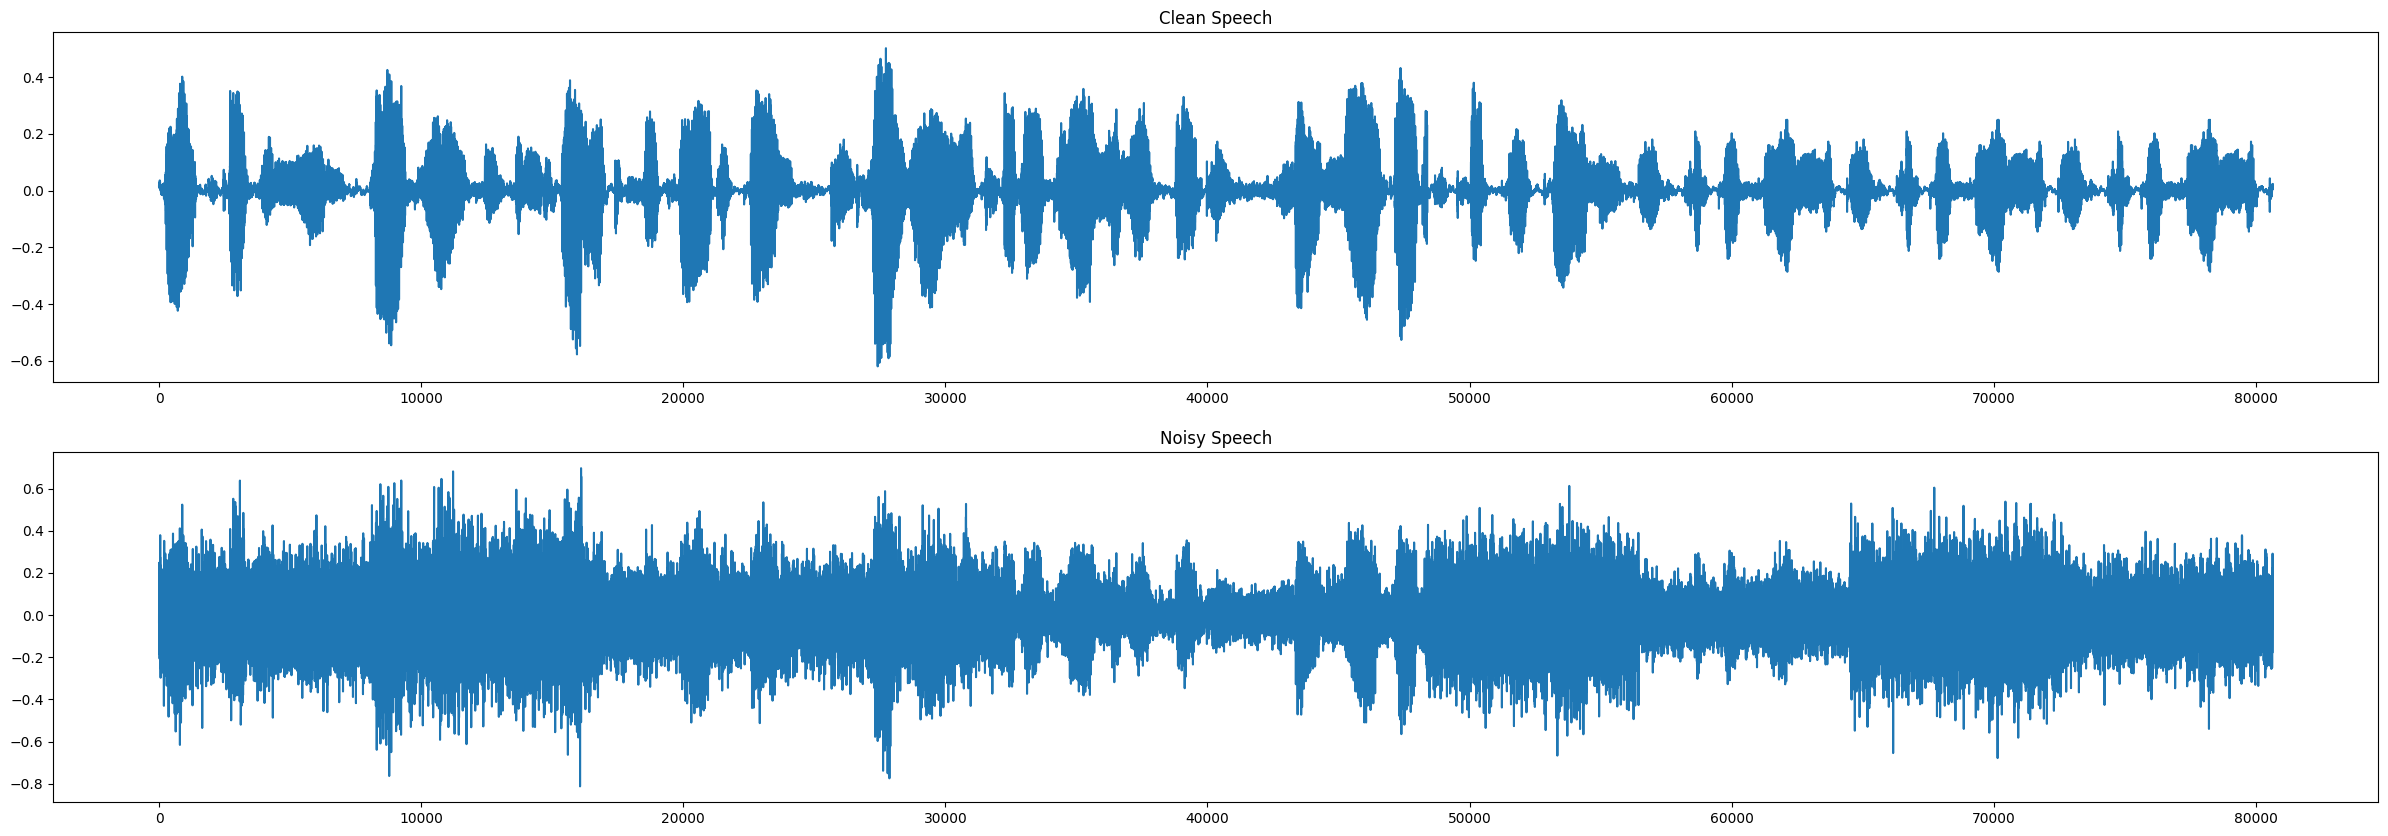

In [315]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.title("Clean Speech")
plt.plot(samples_clean)

plt.subplot(212)
plt.title("Noisy Speech")
plt.plot(samples_noisy_clean)

plt.show()

In [316]:
# Saving and playing clean voice
import soundfile as sf
clean_nb_samples = prod_voice.shape[0]
#Save all frames in one file
clean_long = prod_voice.reshape(1, 10 * frame_length)*10
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("./content/Test/clean_long.wav", clean_long[0,:], 8000, 'PCM_24')

In [317]:
from IPython.display import Audio
Audio('./content/Test/clean_long.wav')

In [318]:
# Saving and playing noisy voice
noise_nb_samples = prod_noisy_voice.shape[0]
#Save all frames in one file
noise_long = prod_noisy_voice.reshape(1, 10 * frame_length)*10
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("./content/Test/noise_long.wav", noise_long[0,:], 8000, 'PCM_24')

In [319]:
from IPython.display import Audio
Audio('./content/Test/noise_long.wav')

# Crea spettrogrammi

In [13]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]
    # Creating several audio frames using sliding windows
    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    # Combining all the frames to single matrix
    sound_data_array = np.vstack(sound_data_list)
    return sound_data_array

In [14]:
def blend_noise_randomly(voice, noise, nb_samples, frame_length):
    """This function takes as input numpy arrays representing frames
    of voice sounds, noise sounds and the number of frames to be created
    and return numpy arrays with voice randomly blend with noise"""

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice

In [15]:
def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    
    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase   #db
    #return stftaudio_magnitude, stftaudio_phase   #no db

In [16]:
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    # we extract the magnitude vectors from the 256-point STFT vectors and 
    # take the first 129-point by removing the symmetric half.

    nb_audio = numpy_audio.shape[0]
    # dim_square_spec = 256/2
    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

In [17]:
def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    count = 0
    for file in list_audio_files:
    # open the audio file
      try:
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        # Getting duration of audio file
        total_duration = librosa.get_duration(y=y, sr=sr)
      except ZeroDivisionError:
        count += 1

        # Check if the duration is atleast the minimum duration
      if (total_duration >= min_duration):
          list_sound_array.append(audio_to_audio_frame_stack(
              y, frame_length, hop_length_frame))
      else:
          print(
              f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)

In [18]:
#Data Prepare
def create_data(noise_dir, voice_dir,path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):
    """This function will randomly blend some clean voices from voice_dir with some noises from noise_dir
    and save the spectrograms of noisy voice, noise and clean voices to disk as well as complex phase,
    time series and sounds. This aims at preparing datasets for denoising training. It takes as inputs
    parameters defined in args module"""

    list_noise_files = os.listdir(noise_dir)
    list_voice_files = os.listdir(voice_dir)

    def remove_ds_store(lst):
        """remove mac specific file if present"""
        if '.DS_Store' in lst:
            lst.remove('.DS_Store')

        return lst

    list_noise_files = remove_ds_store(list_noise_files)
    list_voice_files = remove_ds_store(list_voice_files)

    nb_voice_files = len(list_voice_files)
    nb_noise_files = len(list_noise_files)


    # Extracting noise and voice from folder and convert to numpy
    noise = audio_files_to_numpy(noise_dir, list_noise_files, sample_rate,
                                     frame_length, hop_length_frame_noise, min_duration)

    voice = audio_files_to_numpy(voice_dir, list_voice_files,
                                     sample_rate, frame_length, hop_length_frame, min_duration)

    # Blend some clean voices with random selected noises (and a random level of noise)
    prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(
            voice, noise, nb_samples, frame_length)


    # Squared spectrogram dimensions
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(
            prod_voice, dim_square_spec, n_fft, hop_length_fft)
    #m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(
            #prod_noise, dim_square_spec, n_fft, hop_length_fft)                  #Not required  
    m_amp_db_noisy_voice,  m_pha_noisy_voice = numpy_audio_to_matrix_spectrogram(
            prod_noisy_voice, dim_square_spec, n_fft, hop_length_fft)

    
    np.save(path_save_spectrogram + 'voice_amp_db', m_amp_db_voice)
    #np.save(path_save_spectrogram + 'noise_amp_db', m_amp_db_noise)             #Not required        
    np.save(path_save_spectrogram + 'noisy_voice_amp_db', m_amp_db_noisy_voice)

In [19]:
# Creating folder save the audio spectograms
!mkdir ./content/spectrogram/Test
#!mkdir ./content/spectrogram/Test/label
#!mkdir ./content/spectrogram/Test/noisy
!mkdir ./content/spectrogram/Test/pred 

In [21]:
import os

def count_files_in_folder(folder_path):
    """Conta il numero di file dentro una cartella."""
    return len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

cartella = './content/spectrogram/Vali/label/'
numero_file = count_files_in_folder(cartella)

print(f"Ci sono {numero_file} file nella cartella.")

Ci sono 1000 file nella cartella.


In [40]:
noise_dir="./content/noise/"
voice_dir="./content/clean_speech/"
path_save_spectrogram="./content/spectrogram/Test/"
sample_rate=8000
min_duration=1.0  
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=1
n_fft=255
hop_length_fft=63

In [41]:
create_data(noise_dir=noise_dir,
            voice_dir=voice_dir,
            path_save_spectrogram=path_save_spectrogram,
            sample_rate=sample_rate,
            min_duration=min_duration,
            frame_length=frame_length,
            hop_length_frame=hop_length_frame,
            hop_length_frame_noise=hop_length_frame_noise,
            nb_samples=nb_samples,
            n_fft=n_fft,
            hop_length_fft=hop_length_fft)

In [18]:
idx=np.random.randint(0,10000)

In [26]:
noisy_voice_amp_db = np.load(f'./content/spectrogram/Test/noisy_voice_amp_db.npy')
np.shape(noisy_voice_amp_db)

(10, 128, 128)

(128, 128)


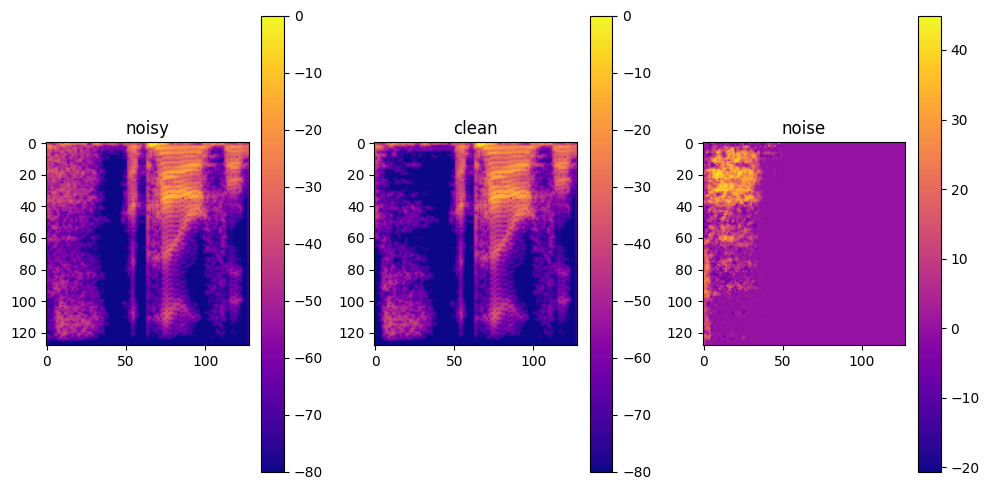

In [19]:
noisy_voice_amp_db = np.load(f'./content/spectrogram/noisy_voice_amp_db.npy')[idx,:,:]
voice_amp_db = np.load(f'./content/spectrogram/voice_amp_db.npy')[idx,:,:]
#noise_amp_db = np.load(f'./content/spectrogram/noise_amp_db.npy')[idx,:,:]
print(np.shape(noisy_voice_amp_db))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
"""
data1 = scale(noisy_voice_amp_db)
data2 = scale(voice_amp_db)
data3 = scale(data1-data2)
"""
data1 = noisy_voice_amp_db
data2 = voice_amp_db
data3 = data1-data2#noise_amp_db

#data1 = librosa.amplitude_to_db(data1, ref=1)
#data2 = librosa.amplitude_to_db(data2, ref=1)
#data3 = librosa.amplitude_to_db(data3, ref=1)


#data3=data1-data2

# Create a figure and a set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first colormap
cax1 = ax1.imshow(data1, cmap='plasma')
ax1.set_title('noisy')
fig.colorbar(cax1, ax=ax1)

# Plot the second colormap
cax2 = ax2.imshow(data2, cmap='plasma')
ax2.set_title('clean')
fig.colorbar(cax2, ax=ax2)

# Plot the third colormap
cax3 = ax3.imshow(data3, cmap='plasma')
ax3.set_title('noise')
fig.colorbar(cax3, ax=ax3)

# Display the plot
plt.tight_layout()
plt.show()

# Model

In [2]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf
# print(tf.__version__)

#Unet network
def unet(input_size = (128,128,1)):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics = ['mae'])
    #model.summary()
    return model

2025-06-12 09:06:13.061052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749719173.086492    3492 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749719173.092711    3492 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 09:06:13.116205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train

In [3]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec
def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

In [4]:
noisy_voice = np.load(f'./content/spectrogram/noisy_voice_amp_db.npy')
voice = np.load(f'./content/spectrogram/voice_amp_db.npy')
noise = noisy_voice-voice

In [5]:
# Shape of noisy voice data
print(noisy_voice.shape)
# Shape of noise data
print(noise.shape)

(50000, 128, 128)
(50000, 128, 128)


In [6]:
# Input
noisy_voice = noisy_voice[:,:,:]
noisy_voice = noisy_voice.reshape(noisy_voice.shape[0],noisy_voice.shape[1],noisy_voice.shape[2],1)
# Output
noise = noise[:,:,:]
noise = noise.reshape(noise.shape[0],noise.shape[1],noise.shape[2],1)

In [7]:
# Shapes after reshaping
print(noisy_voice.shape)
print(noise.shape)

(50000, 128, 128, 1)
(50000, 128, 128, 1)


In [8]:
import matplotlib.pyplot as plt
import pandas
from tensorflow.keras.models import model_from_json
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    """ This function will read noisy voice and clean voice spectrograms created by data_creation mode,
    and train a Unet model on this dataset for epochs and batch_size specified. It saves best models to disk regularly.
    """
    #load noisy voice & clean voice spectrograms created by data_creation mode
    X_in = np.load(path_save_spectrogram +'noisy_voice_amp_db'+".npy")
    X_ou = np.load(path_save_spectrogram +'voice_amp_db'+".npy")
    #Model of noise to predict
    X_ou = X_in - X_ou

    #Check distribution
    #print(stats.describe(X_in.reshape(-1,1)))
    #print(stats.describe(X_ou.reshape(-1,1)))

    #to scale between -1 and 1
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    #Check shape of spectrograms
    #print(X_in.shape)
    #print(X_ou.shape)
    #Check new distribution
    #print(stats.describe(X_in.reshape(-1,1)))
    #print(stats.describe(X_ou.reshape(-1,1)))


    #Reshape for training
    X_in = X_in[:,:,:]
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    X_ou = X_ou[:,:,:]
    X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)
    # print(X_in.shape)
    # print(X_out.shape)
    
    test_size=0.10
    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=test_size, random_state=42)

    generator_nn=unet()

    #Save best models to disk during training
    checkpoint = ModelCheckpoint(weights_path+'/model_unet_best.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

    #states modello
    #generator_nn.summary()

    #Training
    val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(5)
    history = generator_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=val_dataset)
    model_in_json = generator_nn.to_json()

    #Saving Model
    with open(weights_path+'/model_unet.json','w') as json_file:
      json_file.write(model_in_json)

    #Plot training and validation loss (log scale)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.yscale('log')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [9]:
#mkdir ./content/weights

I0000 00:00:1749719217.888016    3492 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11833 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


Epoch 1/10


I0000 00:00:1749719250.033730    3799 service.cc:148] XLA service 0x7f1cdc066ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749719250.033772    3799 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-06-12 09:07:30.373958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749719251.079328    3799 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-06-12 09:07:32.035955: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_co

2025-06-12 09:07:37.115388: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,2,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,16,128,128]{3,2,1,0}, f32[2,16,3,3]{3,2,1,0}, f32[2]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


  2/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - loss: 0.2481 - mae: 0.3854   

I0000 00:00:1749719272.866329    3799 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0275 - mae: 0.1135

2025-06-12 09:09:06.886694: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-12 09:09:07.272725: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,32,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,16,64,64]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0275 - mae: 0.1135

2025-06-12 09:09:26.099565: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-12 09:09:26.135788: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,32,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,16,64,64]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio


Epoch 1: val_loss improved from inf to 0.01574, saving model to ./content/weights/model_unet_best.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 136s 144ms/step - loss: 0.0275 - mae: 0.1135 - val_loss: 0.0157 - val_mae: 0.0860
Epoch 2/10
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0137 - mae: 0.0816
Epoch 2: val_loss did not improve from 0.01574
704/704 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - loss: 0.0137 - mae: 0.0816 - val_loss: 0.0225 - val_mae: 0.1064
Epoch 3/10
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0124 - mae: 0.0767
Epoch 3: val_loss improved from 0.01574 to 0.01483, saving model to ./content/weights/model_unet_best.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 111ms/step - loss: 0.0124 - mae: 0.0767 - val_loss: 0.0148 - val_mae: 0.0839
Epoch 4/10
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0117 - mae: 0.0740
Epoch 4: val_loss did not improve from 0.01483
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 113ms/step - loss: 0.0117 - mae: 0.0740 - val_loss: 0.0182 - val_mae: 0.0928
Epoc

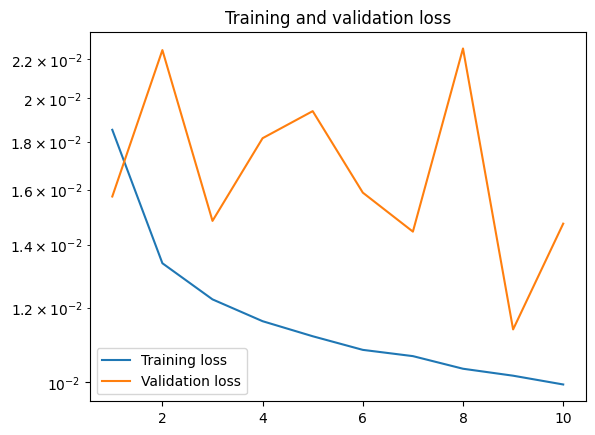

In [10]:
training_unet(path_save_spectrogram, './content/weights', epochs=10, batch_size=64)

# Predict

In [214]:
#Helper Functions
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct


def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

In [215]:
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import model_from_json
import soundfile as sf

def prediction(weights_path, audio_dir_prediction, dir_save_prediction, audio_input_prediction,
audio_output_prediction):
    """ This function takes as input pretrained weights, noisy voice sound to denoise, predict
    the denoise sound and save it to disk.
    """

    # load json and create model
    json_file = open(weights_path + 'model_unet.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model/
    loaded_model.load_weights(weights_path + 'model_unet_best.keras')
    print("Loaded model from disk")

    # Extracting noise and voice from folder and convert to numpy
    audio = audio_files_to_numpy(audio_dir_prediction, audio_input_prediction, sample_rate,
                                 frame_length, hop_length_frame, min_duration)

    #Dimensions of squared spectrogram
    dim_square_spec = int(n_fft / 2) + 1
    print(dim_square_spec)

    # Create Amplitude and phase of the sounds
    m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
        audio, dim_square_spec, n_fft, hop_length_fft)

    #global scaling to have distribution -1/1
    X_in = scaled_in(m_amp_db_audio)
    #Reshape for prediction
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    #Prediction using loaded network
    X_pred = loaded_model.predict(X_in)
    #Rescale back the noise model
    inv_sca_X_pred = inv_scaled_ou(X_pred)
    #Remove noise model from noisy speech
    X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
    #Reconstruct audio from denoised spectrogram and phase
    print(X_denoise.shape)
    print(m_pha_audio.shape)
    print(frame_length)
    print(hop_length_fft)
    audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
    #Number of frames
    nb_samples = audio_denoise_recons.shape[0]
    #Save all frames in one file
    denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10
    # librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
    sf.write(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 8000, 'PCM_24')
    # wavfile.write(dir_save_prediction + audio_output_prediction, 1000, denoise_long[0,:])

In [320]:
prediction("./content/weights/", "./content/Test/", "./content/Test/", ["noise_long.wav"],
"pred_voice.wav")

Loaded model from disk
128
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(10, 128, 128)
(10, 128, 128)
8064
63


# view predictions

In [321]:
from IPython.display import Audio
Audio('./content/Test/clean_long.wav')

In [322]:
Audio('./content/Test/noise_long.wav')

In [323]:
import librosa
import numpy as np
import soundfile as sf

# Carica l'audio
y, sr = librosa.load('./content/Test/pred_voice.wav', sr=None)

# Aumenta il volume di un fattore 10
gain_factor = 10
y_amplified = y * gain_factor

# Clipping per evitare distorsione (valori devono restare tra -1 e 1)
y_amplified = np.clip(y_amplified, -1.0, 1.0)

# Salva l'audio amplificato
sf.write('./content/Test/pred_voice_amplified.wav', y_amplified, sr)

In [324]:
Audio('./content/Test/pred_voice_amplified.wav')

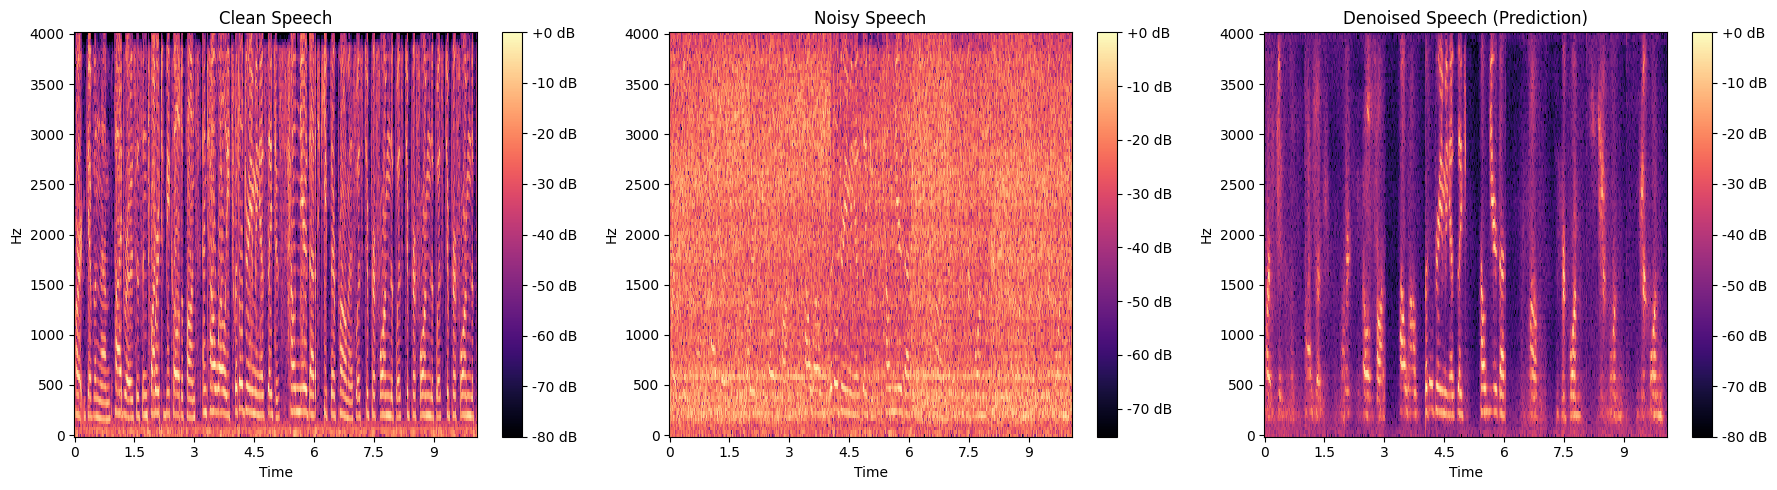

In [325]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

# Parametri
n_fft = 255
hop_length_fft = 63
dim_square_spec = n_fft // 2 + 1  # 129

# Funzioni già fornite
def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)
    stftaudio_magnitude_db = librosa.amplitude_to_db(stftaudio_magnitude, ref=np.max)
    return stftaudio_magnitude_db, stftaudio_phase

# Caricamento audio
path_clean = './content/Test/clean_long.wav'
path_noise = './content/Test/noise_long.wav'
path_pred  = './content/Test/pred_voice.wav'

audio_clean, sr = sf.read(path_clean)
audio_noise, _ = sf.read(path_noise)
audio_pred, _  = sf.read(path_pred)

# Spettrogrammi
spec_clean, _ = audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio_clean)
spec_noise, _ = audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio_noise)
spec_pred, _  = audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio_pred)

# Plotting
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
librosa.display.specshow(spec_clean, sr=sr, hop_length=hop_length_fft, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Clean Speech')

plt.subplot(1, 3, 2)
librosa.display.specshow(spec_noise, sr=sr, hop_length=hop_length_fft, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Speech')

plt.subplot(1, 3, 3)
librosa.display.specshow(spec_pred, sr=sr, hop_length=hop_length_fft, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Denoised Speech (Prediction)')

plt.tight_layout()
plt.show()